# Rayleigh-Marchenko redatuming with python wavefield separated data

In [160]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from scipy.io import loadmat

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *

from pymarchenko.raymarchenko import RayleighMarchenko

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Inputs

In [161]:
inputfile = '../data/raymarchenko/input_pythonsep.npz' # Python separation

vel = 2400.0        # velocity
tsoff = 0.06        # direct arrival time shift source side
troff = 0.06        # direct arrival time shift receiver side
nsmooth = 10        # time window smoothing 
nfmax = 300         # max frequency for MDC (#samples)
n_iter = 30         # iterations
kt = 120            # portion of time axis to remove
convolvedata = False # Apply convolution to data

In [162]:
inputdata = np.load(inputfile)

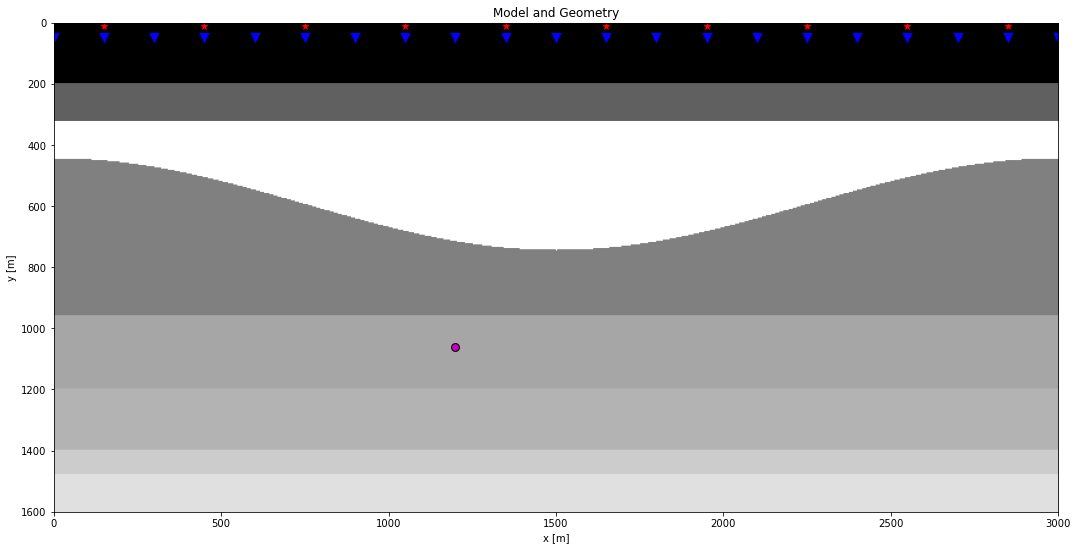

In [163]:
# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

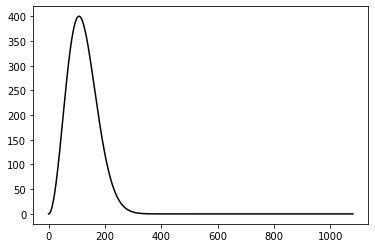

In [164]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# separated data
Vzu = inputdata['Vzu']
Vzd = inputdata['Vzd']

wav = inputdata['wav']
wav = wav / np.max(np.abs(np.fft.fft(wav))*dt)
wav_c = np.argmax(wav)

plt.figure()
plt.plot(np.abs(np.fft.rfft(wav, 2*nt-1)), 'k')

Read subsurface fields and wavelet to apply to subsurface fields

In [165]:
Gsub = inputdata['Gsub']
G0sub = inputdata['G0sub']

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

Convolve data with wavelet (optional)

In [166]:
if convolvedata:
    Vzu = dt * np.apply_along_axis(convolve, -1, Vzu, wav, mode='full')
    Vzu = Vzu[..., wav_c:][..., :nt]
    Vzd = dt * np.apply_along_axis(convolve, -1, Vzd, wav, mode='full')
    Vzd = Vzd[..., wav_c:][..., :nt]

    Gsub = dt * np.apply_along_axis(convolve, -1, Gsub, wav, mode='full')
    Gsub = Gsub[..., wav_c:][..., :nt]

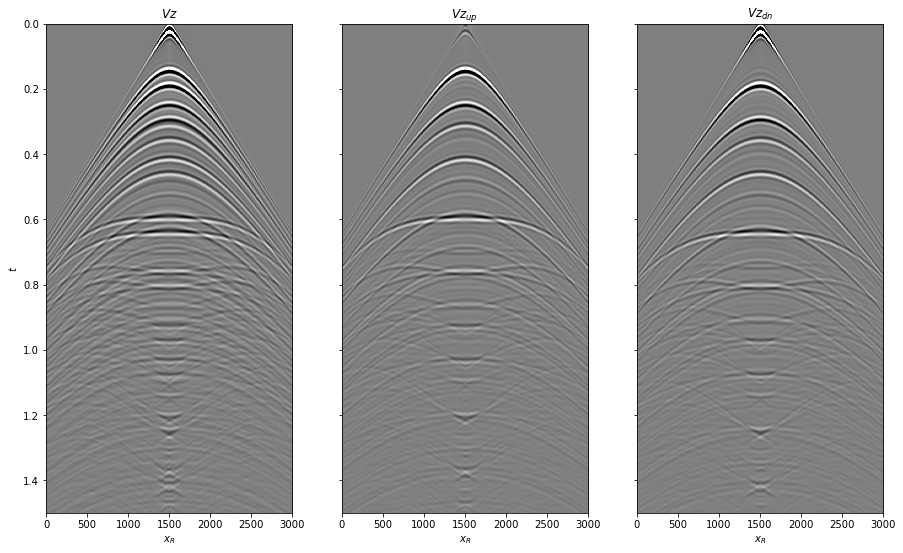

In [167]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(Vzu[ns//2].T+Vzd[ns//2].T, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$Vz$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(Vzu[ns//2].T, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Vz_{up}$'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(Vzd[ns//2].T, cmap='gray', vmin=-1e-1, vmax=1e-1, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$Vz_{dn}$'), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);

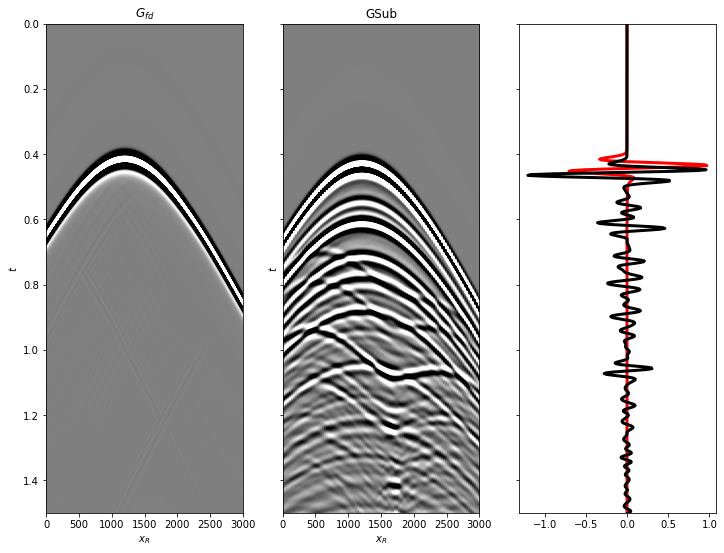

In [168]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 9))
axs[0].imshow(G0sub, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$G_{fd}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(Gsub, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('GSub'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);
axs[2].plot(G0sub[:, nr//2].T/G0sub.max(), t, 'r', lw=3)
axs[2].plot(Gsub[:, ns//2].T/Gsub.max(), t, 'k', lw=3)
axs[2].set_ylim(1.5, 0);

## Marchenko preparation

Create window

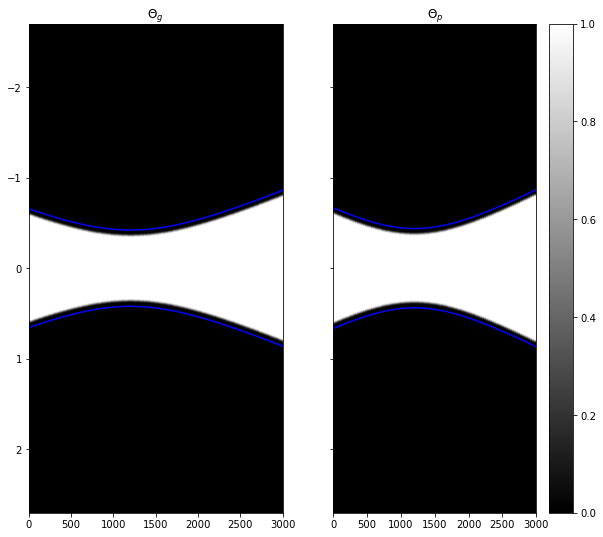

In [169]:
# direct arrival window - traveltime
directVSr = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVSr_off = directVSr - troff
directVSs = np.sqrt((vs[0]-s[0])**2+(vs[1]-s[1])**2)/vel
directVSs_off = directVSs - tsoff

# window
idirectVSr_off = np.round(directVSr_off/dt).astype(np.int)
idirectVSs_off = np.round(directVSs_off/dt).astype(np.int)
wr = np.zeros((nr, nt))
ws = np.zeros((ns, nt))

for ir in range(nr):
    wr[ir, :idirectVSr_off[ir]]=1
for ir in range(ns):    
    ws[ir, :idirectVSs_off[ir]]=1
wr = np.hstack((np.fliplr(wr), wr[:, 1:]))
ws = np.hstack((np.fliplr(ws), ws[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    wr  = filtfilt(smooth, 1, wr)
    ws  = filtfilt(smooth, 1, ws)
    
fig, ax = plt.subplots(1, 2,  sharey=True, figsize=(10, 9))
ax[0].imshow(wr.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax[0].plot(r[0], directVSr,'b'),ax[0].plot(r[0], -directVSr,'b')
ax[0].set_title(r'$\Theta_g$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax[0].axis('tight')
im=ax[1].imshow(ws.T, cmap='gray', extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
ax[1].plot(s[0], directVSs,'b'),ax[1].plot(s[0], -directVSs,'b')
ax[1].set_title(r'$\Theta_p$'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
ax[1].axis('tight')

fig.colorbar(im,ax=ax[1]);

Create analytical direct wave

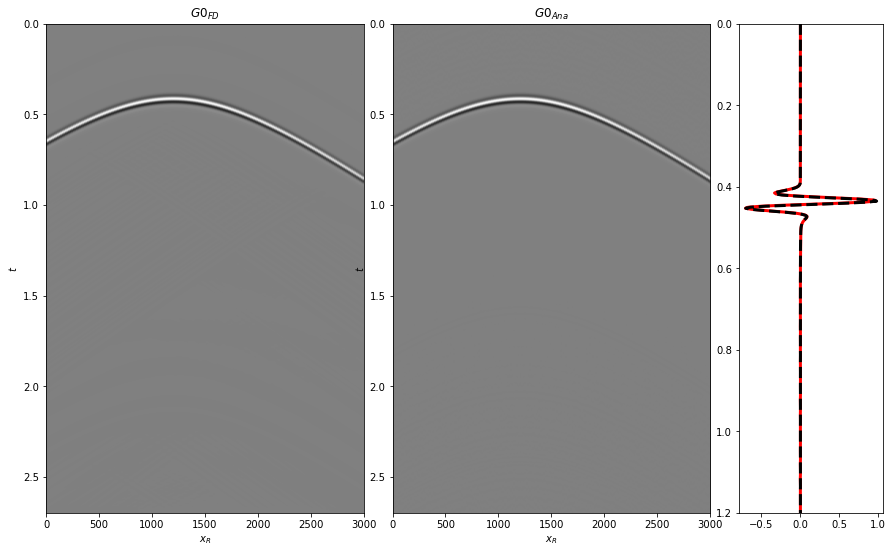

In [170]:
G0sub_ana = directwave(wav[wav_c-60:wav_c+60], directVSr, nt, dt, nfft=2**11)

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'r', lw=3)
ax3.plot(G0sub_ana[:, nr//2]/G0sub_ana.max(), t, '--k', lw=3)
ax3.set_ylim(1.2, 0);

## Inversion

In [171]:
# Add negative time to Vzu operators
Vzutwosided = np.concatenate((np.zeros((ns, nr, nt-1)), Vzu), axis=-1)
Vzutwosided_fft = np.fft.rfft(Vzutwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Vzutwosided_fft = Vzutwosided_fft[...,:nfmax]
Vzutwosided_fft = Vzutwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Vzuop = MDC(Vzutwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, 
            transpose=False, dtype='complex64')
dottest(Vzuop, (2*nt-1)*ns, (2*nt-1)*nr, verb=True)

Vzu1op = MDC(Vzutwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, 
             transpose=False, conj=True, dtype='complex64')
dottest(Vzu1op, (2*nt-1)*ns, (2*nt-1)*nr, verb=True)

Dot test passed, v^T(Opu)=-70.830477 - u^T(Op^Tv)=-70.830477
Dot test passed, v^T(Opu)=140.312792 - u^T(Op^Tv)=140.312792


True

In [172]:
# Add negative time to Vzd operators
Vzdtwosided = np.concatenate((np.zeros((ns, nr, nt-1)), Vzd), axis=-1)
Vzdtwosided_fft = np.fft.rfft(Vzdtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Vzdtwosided_fft = Vzdtwosided_fft[...,:nfmax]
Vzdtwosided_fft = Vzdtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Vzdop = MDC(Vzdtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, 
            transpose=False, dtype='complex64')
dottest(Vzdop, (2*nt-1)*ns, (2*nt-1)*nr, verb=True)

Vzd1op = MDC(Vzdtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, 
             transpose=False, conj=True, dtype='complex64')
dottest(Vzd1op, (2*nt-1)*ns, (2*nt-1)*nr, verb=True)

Dot test passed, v^T(Opu)=313.753997 - u^T(Op^Tv)=313.753997
Dot test passed, v^T(Opu)=-209.771938 - u^T(Op^Tv)=-209.771938


True

In [173]:
# Input focusing function
fd_plus =  np.concatenate((np.flipud(G0sub), np.zeros((nt-1, nr))))

Create Marchenko operator

In [174]:
Rollop = Roll((2*nt-1) * ns,
              dims=(2*nt-1, ns),
              dir=0, shift=-1)
Wgop = Diagonal(wr.T.flatten())
Wpop = Diagonal(ws.T.flatten())

Dop = VStack([HStack([Wpop*Vzdop, Wpop*Vzuop]),
              HStack([Wpop*Rollop*Vzu1op, Wpop*Rollop*Vzd1op])])
Mop = Dop*BlockDiag([Wgop, Wgop])
Gop = VStack([HStack([Vzdop, Vzuop]),
              HStack([Rollop*Vzu1op, Rollop*Vzd1op])])

dottest(Gop, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=458.171686 - u^T(Op^Tv)=458.171686
Dot test passed, v^T(Opu)=49.597015 - u^T(Op^Tv)=49.597015


Create data, adjoint and inverse focusing functions

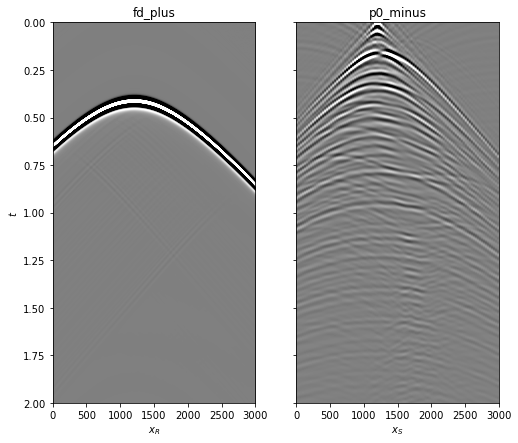

In [175]:
p0_minus = Vzuop*fd_plus.ravel()
p0_minus = p0_minus.reshape((2*nt-1), ns).T
p0_minus_2 = np.concatenate((p0_minus, np.zeros((ns, 2*nt-1))))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 7))
axs[0].imshow(np.flipud(fd_plus), cmap='gray', vmin=-1e7, vmax=1e7, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title('fd_plus'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0)
axs[1].imshow(p0_minus.T, cmap='gray', vmin=-1e7, vmax=1e7,
              extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title('p0_minus'), axs[1].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

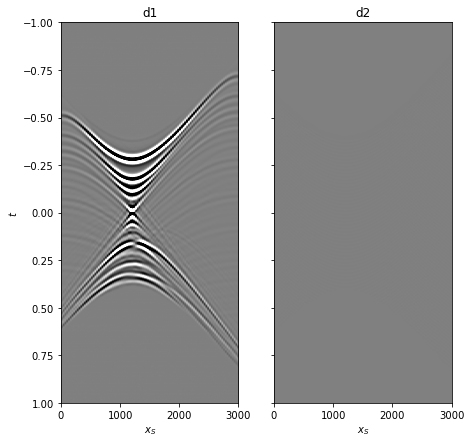

In [176]:
dinp = np.concatenate((np.zeros((2*nt-1, nr)), fd_plus), axis=0)
d = -Dop * dinp.ravel()
d = d.reshape(2*(2*nt-1), ns)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(7, 7))
axs[0].imshow(d[:(2*nt-1)], cmap='gray', vmin=-1e7, vmax=1e7, 
              extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title('d1'), axs[0].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(d[(2*nt-1):], cmap='gray', vmin=-1e7, vmax=1e7, 
              extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title('d2'), axs[1].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

In [177]:
%%time 
f1_adj = Mop.H*d.ravel()
f1_inv = lsqr(Mop, d.ravel(), iter_lim=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), nr)
f1_inv = f1_inv.reshape(2*(2*nt-1), nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 436522 rows and 868722 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.133e+09  1.133e+09    1.0e+00  6.9e-10
     1  0.00000e+00   7.946e+08  7.946e+08    7.0e-01  6.8e-01   1.1e+00  1.0e+00
     2  0.00000e+00   6.122e+08  6.122e+08    5.4e-01  4.3e-01   1.8e+00  2.4e+00
     3  0.00000e+00   4.436e+08  4.436e+08    3.9e-01  2.7e-01   2.3e+00  4.2e+00
     4  0.00000e+00   3.604e+08  3.604e+08    3.2e-01  3.1e-01   2.6e+00  5.7e+00
     5  0.00000e+00   3.211e+08  3.211e+08    2.8e-01  1.9e-01   3.3e+00  8.0e+00
     6  0.00000e+00   2.750e+08  2.750e+08    2.4e-01  2.0e-01   3.7e+00  1.0e+01
     7  0.00000e+00   2.429e+08  2.429e+08    2.1e-01  1.3e-01   4.2e+00  1.3e+01
     8  0.00000e+00   2.239e+0

Add initial guess to estimated focusing functions

In [178]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, nr)),
                                      np.concatenate((np.fliplr(G0sub.T).T, 
                                                      np.zeros((nt-1, nr))), axis=0)))
f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, nr)),
                                      fd_plus))

Estimate Green's functions

In [179]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), ns)
g_inv = g_inv.reshape(2*(2*nt-1), ns)

Extract up and down focusing and Green's functions from model vectors

In [180]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

Visualization

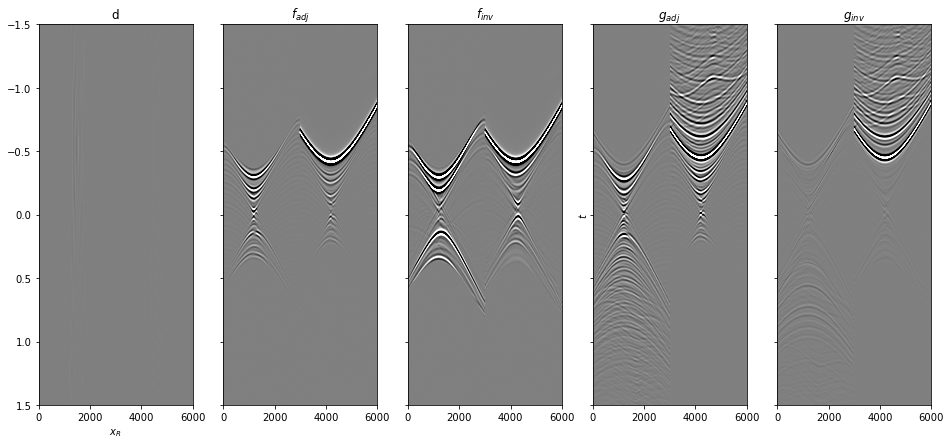

In [181]:
# Need to recreate combined data as new implementation stacks over time instead of space
#d = np.concatenate((d[:(2*nt-1)], d[(2*nt-1):]), axis=1).T
f1_adj_tot = np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T
f1_inv_tot = np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T
g_adj = np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T
g_inv = np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(f1_adj_tot.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[2].imshow(f1_inv_tot.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[3].imshow(g_adj.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[4].imshow(g_inv.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1.5, -1.5);

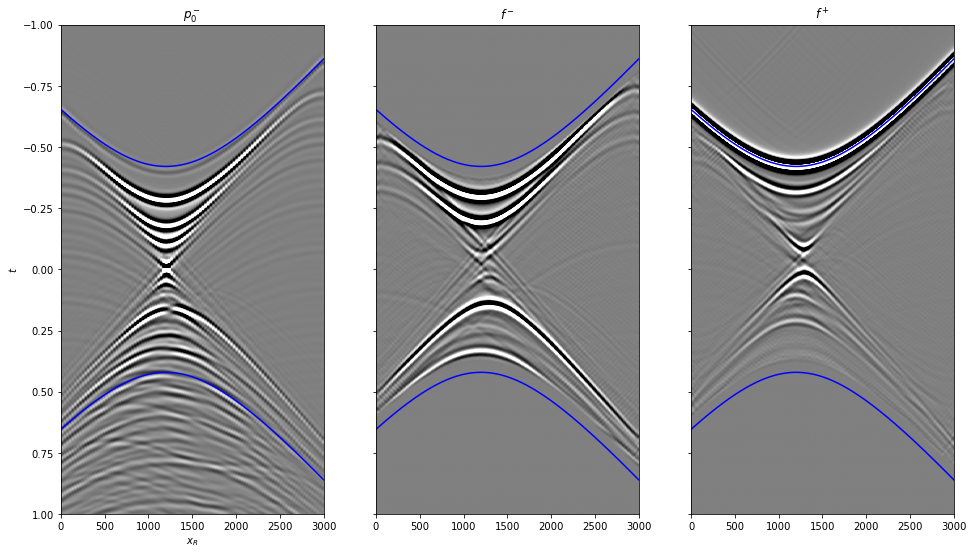

In [182]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(r[0], directVSr,'b'),axs[0].plot(r[0], -directVSr,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVSr,'b'),axs[1].plot(r[0], -directVSr,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVSr,'b'),axs[2].plot(r[0], -directVSr,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

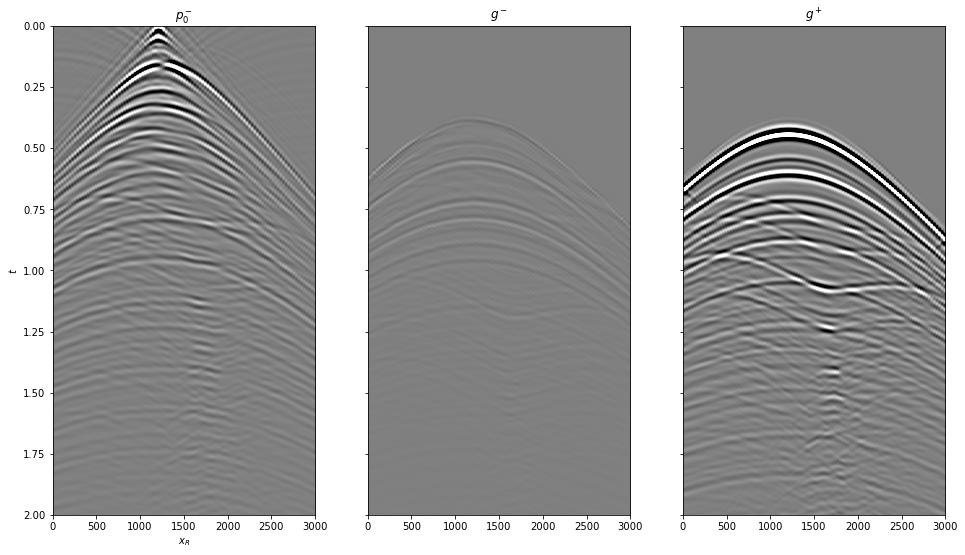

In [183]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow((1-ws.T) * g_inv_minus.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow((1-ws.T) * g_inv_plus.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

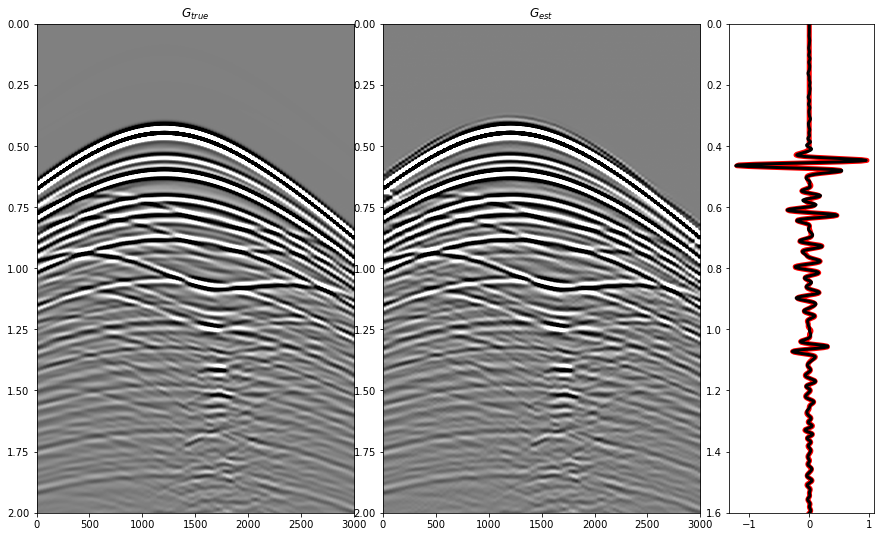

In [184]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

Gsubnorm = Gsub/Gsub.max()
g_inv_tot_norm = -(1-ws[:, nt-1:]) * (g_inv_tot[:, nt-1:])/(-g_inv_tot).max()

ax1.imshow(Gsubnorm, cmap='gray', vmin=-1e-1, vmax=1e-1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(g_inv_tot_norm.T, cmap='gray', vmin=-1e-1, vmax=1e-1, 
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G_{est}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)

ax3.plot(Gsub[:, ns//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(-(g_inv_tot[ns//2, nt-1:])/(-g_inv_tot).max(), t, 'k', lw=3)
ax3.set_ylim(1.6, 0);

## Examples of Marchenko class usage for single virtual point

In [185]:
"""
rm = RayleighMarchenko(Vzdtwosided_fft.transpose(1, 2, 0), Vzutwosided_fft.transpose(1, 2, 0), 
                       nt=nt, dt=dt, dr=dr,
                       nfmax=nfmax, wav=wav, toff=troff, nsmooth=nsmooth,
                       dtype='float64', saveVt=True, prescaled=False)
"""

rm = RayleighMarchenko(Vzd, Vzu, dt=dt, dr=dr,
                       nfmax=nfmax, wav=wav, toff=troff, nsmooth=nsmooth,
                       dtype='float64', saveVt=True, prescaled=False)

In [186]:
# True G0
f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    rm.apply_onepoint(directVSs, directVSr, G0=G0sub.T, rtm=True, greens=True, 
                      dottest=True, **dict(iter_lim=n_iter, show=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f
"""
# Analytic G0 (results will have different amplitudes!)
f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    rm.apply_onepoint(directVSs, directVSr, nfft=2**11, rtm=True, greens=True, 
                      dottest=True, **dict(iter_lim=n_iter, show=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f
"""

Dot test passed, v^T(Opu)=-129.462652 - u^T(Op^Tv)=-129.462652
Dot test passed, v^T(Opu)=29.306343 - u^T(Op^Tv)=29.306343
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 436522 rows and 868722 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.133e+09  1.133e+09    1.0e+00  6.9e-10
     1  4.94044e+04   7.946e+08  7.946e+08    7.0e-01  6.8e-01   1.1e+00  1.0e+00
     2  3.54415e+03   6.122e+08  6.122e+08    5.4e-01  4.3e-01   1.8e+00  2.4e+00
     3  8.17393e+03   4.436e+08  4.436e+08    3.9e-01  2.7e-01   2.3e+00  4.2e+00
     4  4.82239e+04   3.604e+08  3.604e+08    3.2e-01  3.1e-01   2.6e+00  5.7e+00
     5  5.35661e+04   3.211e+08  3.211e+08    2.8e-01  1.9e-01   3.3e+00  8.0e+00
     6  5.09500e+04   2.750e+08  2.750e+08    2.4e-01  2.0e-01   3.7e+00

'\n# Analytic G0 (results will have different amplitudes!)\nf1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f =     rm.apply_onepoint(directVSs, directVSr, nfft=2**11, rtm=True, greens=True, \n                      dottest=True, **dict(iter_lim=n_iter, show=True))\ng_inv_tot_f = g_inv_minus_f + g_inv_plus_f\n'

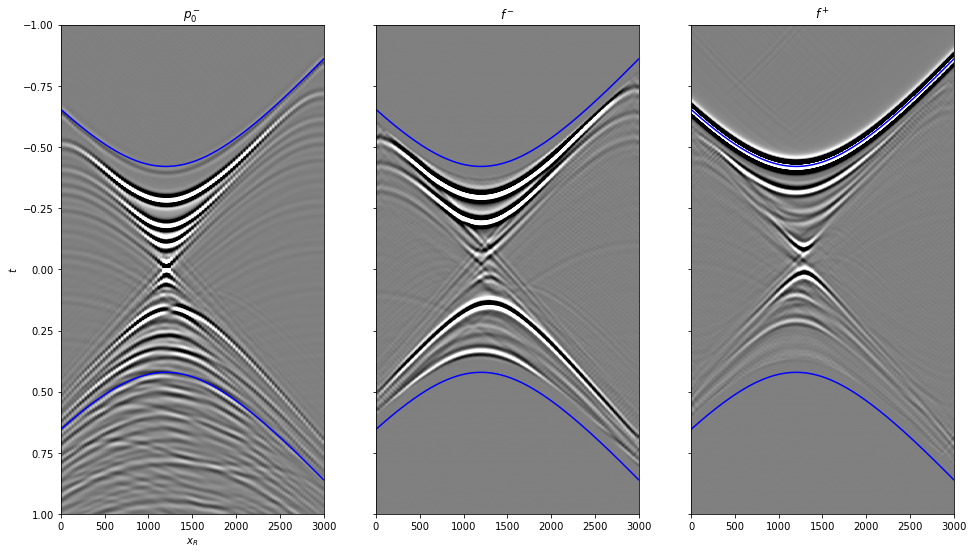

In [187]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus_f.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(r[0], directVSr,'b'),axs[0].plot(r[0], -directVSr,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus_f.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].plot(r[0], directVSr,'b'),axs[1].plot(r[0], -directVSr,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus_f.T, cmap='gray', vmin=-1e7, vmax=1e7, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].plot(r[0], directVSr,'b'),axs[2].plot(r[0], -directVSr,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

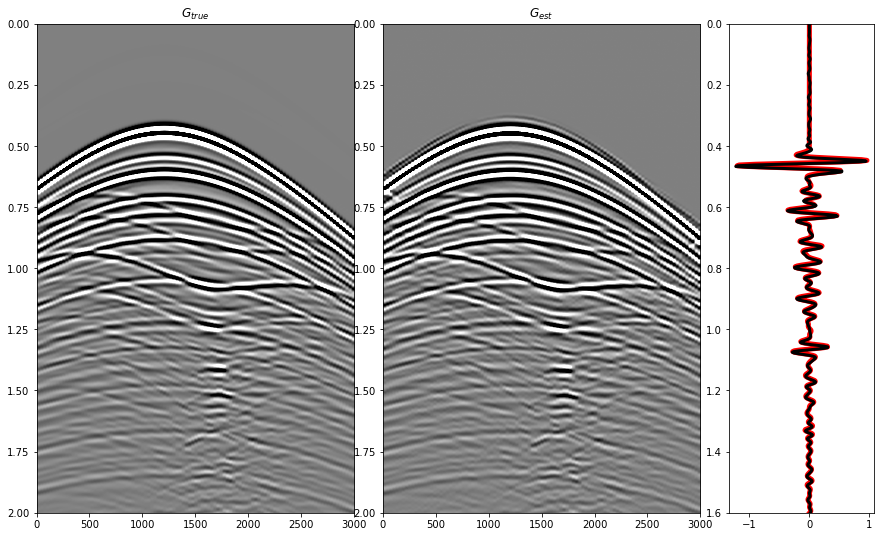

In [188]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

Gsubnorm = Gsub/Gsub.max()
g_inv_tot_norm = -(1-ws[:, nt-1:]) * (g_inv_tot_f[:, nt-1:])/(-g_inv_tot_f).max()

ax1.imshow(Gsubnorm, cmap='gray', vmin=-1e-1, vmax=1e-1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(g_inv_tot_norm.T, cmap='gray', vmin=-1e-1, vmax=1e-1, 
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G_{est}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)

ax3.plot(Gsub[:, ns//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(-(g_inv_tot_f[ns//2, nt-1:])/(-g_inv_tot_f).max(), t, 'k', lw=3)
ax3.set_ylim(1.6, 0);

## Examples of Marchenko class usage for multiple points

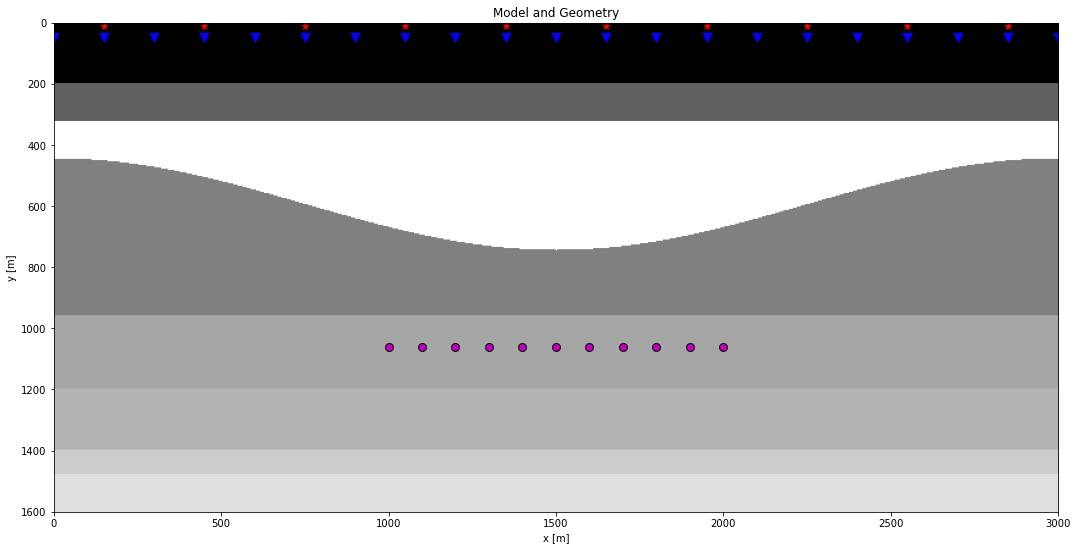

In [189]:
nvs = 11
vs = [np.arange(11)*100 + 1000, 
      np.ones(11)*1060]

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

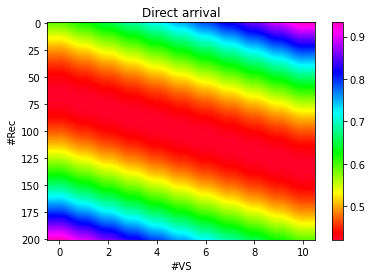

In [190]:
# direct arrival window - traveltime
directVSr = np.sqrt((vs[0]-r[0][:, np.newaxis])**2+(vs[1]-r[1][:, np.newaxis])**2)/vel
directVSr_off = directVSr - troff
directVSs = np.sqrt((vs[0]-s[0][:, np.newaxis])**2+(vs[1]-s[1][:, np.newaxis])**2)/vel
directVSs_off = directVSs - tsoff

plt.figure()
im = plt.imshow(directVSr, cmap='gist_rainbow')
plt.axis('tight')
plt.xlabel('#VS'),plt.ylabel('#Rec'),plt.title('Direct arrival')
plt.colorbar(im);

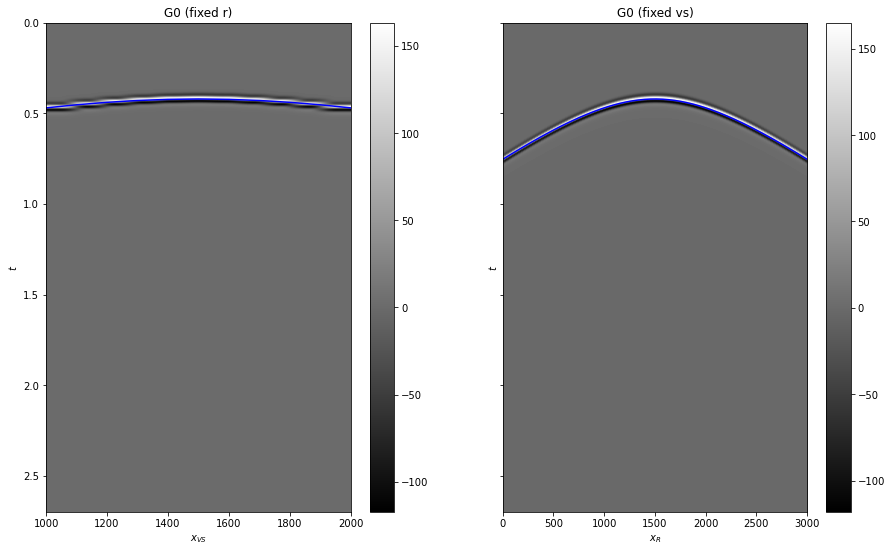

In [191]:
G0sub_ana = np.zeros((nr, nvs, nt))
for ivs in range(nvs):
    G0sub_ana[:, ivs] = directwave(wav, directVSr[:,ivs], nt, dt, nfft=int(2**(np.ceil(np.log2(nt))))).T

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(G0sub_ana[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], t[0]))
axs[0].plot(vs[0], directVSr[nr//2],'b')
axs[0].set_title('G0 (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(G0sub_ana[:,nvs//2].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].plot(r[0], directVSr[:, nvs//2],'b')
axs[1].set_title('G0 (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

In [192]:
rm = RayleighMarchenko(Vzd, Vzu, dt=dt, dr=dr,
                       nfmax=nfmax, wav=wav, toff=troff, nsmooth=nsmooth,
                       dtype='float64', saveVt=True, prescaled=False)

f1_inv_minus_f, f1_inv_plus_f, p0_minus_f, g_inv_minus_f, g_inv_plus_f = \
    rm.apply_multiplepoints(directVSs, directVSr, G0=G0sub_ana, rtm=True, greens=True, 
                            dottest=True, **dict(iter_lim=n_iter, show=True))
g_inv_tot_f = g_inv_minus_f + g_inv_plus_f

Dot test passed, v^T(Opu)=616.058837 - u^T(Op^Tv)=616.058837
Dot test passed, v^T(Opu)=344.432065 - u^T(Op^Tv)=344.432065
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 4801742 rows and 9555942 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   4.976e+03  4.976e+03    1.0e+00  1.6e-04
     1 -1.51503e-01   3.512e+03  3.512e+03    7.1e-01  6.7e-01   1.1e+00  1.0e+00
     2 -1.25013e-01   2.676e+03  2.676e+03    5.4e-01  4.4e-01   1.8e+00  2.4e+00
     3 -3.78875e-02   1.960e+03  1.960e+03    3.9e-01  2.6e-01   2.3e+00  4.2e+00
     4 -7.94202e-02   1.589e+03  1.589e+03    3.2e-01  3.0e-01   2.6e+00  5.7e+00
     5 -8.85614e-02   1.422e+03  1.422e+03    2.9e-01  2.0e-01   3.3e+00  7.9e+00
     6 -8.85107e-02   1.214e+03  1.214e+03    2.4e-01  2.0e-01   3.8e+

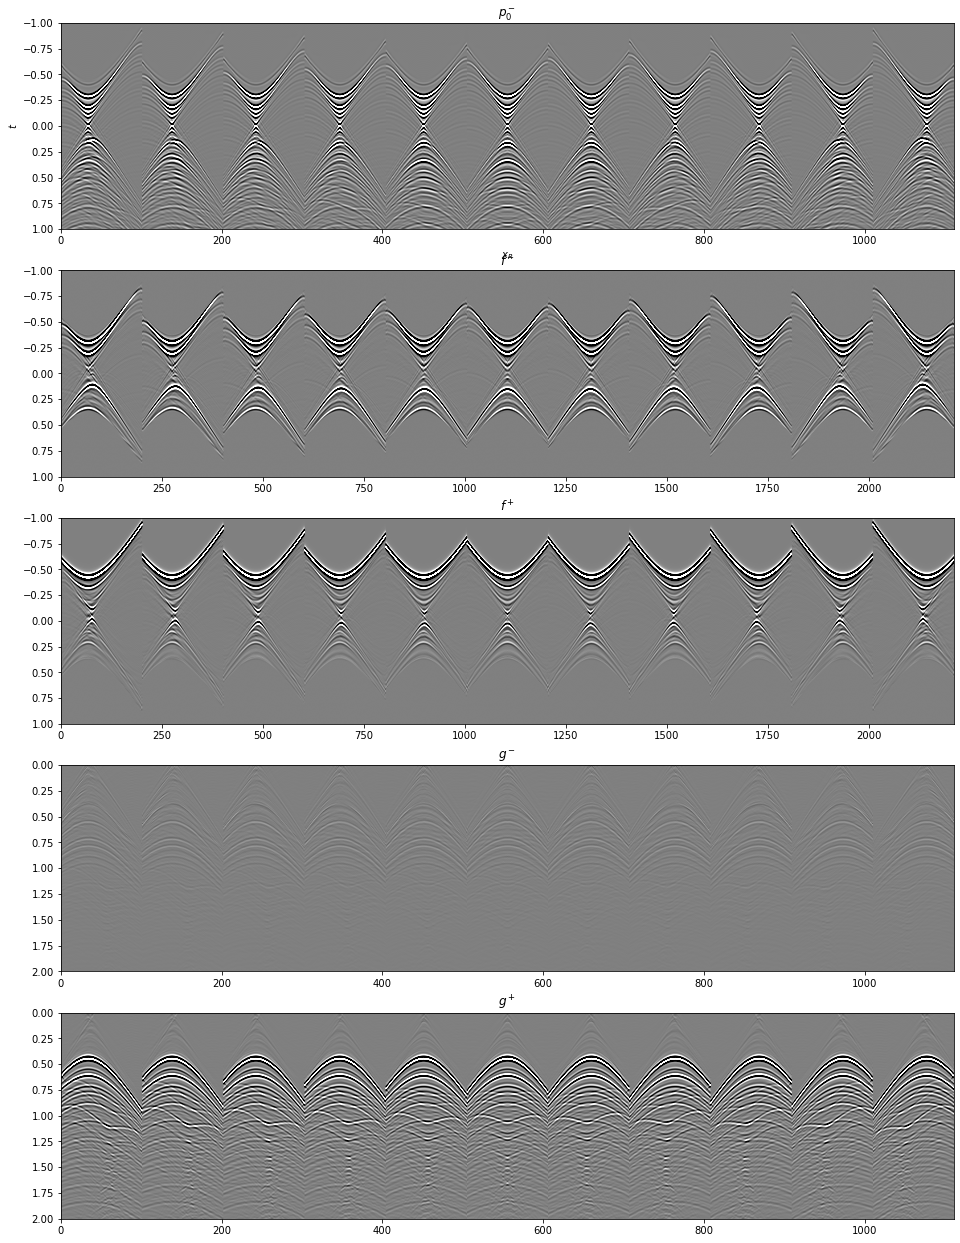

In [193]:
vmax = 1e1

fig, axs = plt.subplots(5, 1, figsize=(16, 22))
axs[0].imshow(np.swapaxes(p0_minus_f, 0, 1).reshape(ns*nvs, 2*nt-1).T, cmap='gray', 
              vmin=-vmax, vmax=vmax, extent=(0, ns*nvs, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(np.swapaxes(f1_inv_minus_f, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-vmax, vmax=vmax, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1)
axs[2].imshow(np.swapaxes(f1_inv_plus_f, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-vmax, vmax=vmax, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1)
axs[3].imshow(np.swapaxes(g_inv_minus_f, 0, 1).reshape(ns*nvs,2*nt-1).T, cmap='gray', 
              vmin=-vmax, vmax=vmax, extent=(0, ns*nvs, t[-1], -t[-1]))
axs[3].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0)
axs[4].imshow(np.swapaxes(g_inv_plus_f, 0, 1).reshape(ns*nvs,2*nt-1).T, cmap='gray', 
              vmin=-vmax, vmax=vmax, extent=(0, ns*nvs, t[-1], -t[-1]))
axs[4].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(2, 0);

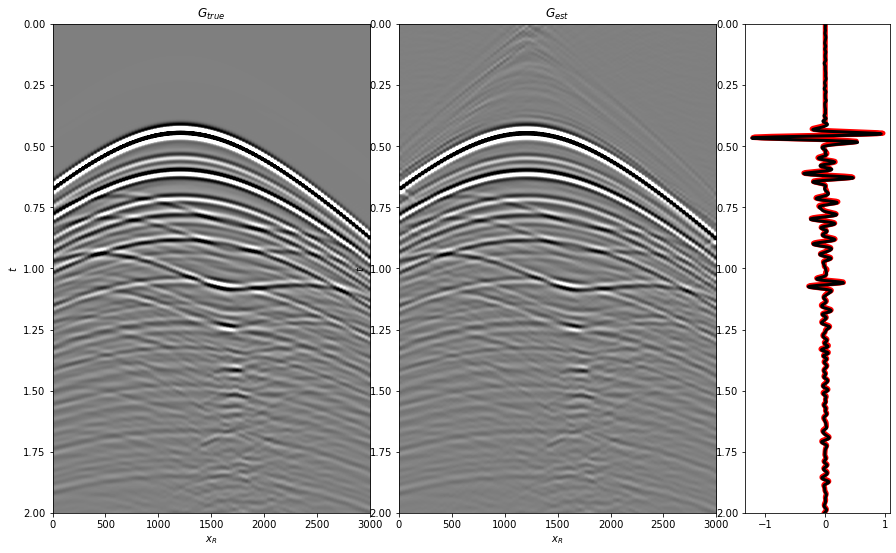

In [196]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

vmax = 2e-1
ax1.imshow(Gsub/Gsub.max(), cmap='gray', vmin=-vmax, vmax=vmax,
           extent=(s[0,0], s[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0)
ax2.imshow(-g_inv_tot_f[:, 2].T/g_inv_tot_f.max(), cmap='gray', vmin=-vmax, vmax=vmax,
              extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0)

ax3.plot(Gsub[:, ns//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(-g_inv_tot_f[ns//2, 2, nt-1:]/(-g_inv_tot_f).max(), t, 'k', lw=3)
ax3.set_ylim(2, 0);